In [ ]:
import numpy as np
import pandas as pd
from math import sqrt

from matplotlib import pyplot
from pandas import read_csv

from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pywt
np.random.seed(2020)
from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.layers.core import Dense, Activation
from keras.regularizers import l1_l2, l2
from numpy import array
import warnings

import matplotlib.pyplot as plt
from keras import optimizers

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go








# import os
# import tensorflow as tf
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# tf.random.set_seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  #n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var(t-%d)' % (i))] #for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var(t)')] #for j in range(n_vars)]
    else:
      names += [('var(t+%d)' % (i))] #for j in range(n_vars)]
# put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/res_data.xlsx',index_col='Date')


In [ ]:

df

,Outflow,Level,Inflow,Rainfall,"Outflow,m3","Inflow,m3"
Date,,,,,,
2000-01-01,37.731481,127.41,29.513889,0.00,3260000,2550000
2000-01-02,23.611111,127.41,23.611111,0.00,2040000,2040000
2000-01-03,40.162037,127.39,23.726852,0.00,3470000,2050000
2000-01-04,14.930556,127.40,23.148148,0.00,1290000,2000000
2000-01-05,24.074074,127.39,15.856481,0.00,2080000,1370000
...,...,...,...,...,...,...
2019-12-27,28.703704,128.85,19.791667,3.61,2480000,1710000
2019-12-28,28.472222,128.83,10.648148,0.00,2460000,920000
2019-12-29,28.703704,128.81,10.879630,0.00,2480000,940000


In [ ]:
cols = list(df)[:4]
data = df[cols].astype(float)

In [ ]:
data

,Outflow,Level,Inflow,Rainfall
Date,,,,
2000-01-01,37.731481,127.41,29.513889,0.00
2000-01-02,23.611111,127.41,23.611111,0.00
2000-01-03,40.162037,127.39,23.726852,0.00
2000-01-04,14.930556,127.40,23.148148,0.00
2000-01-05,24.074074,127.39,15.856481,0.00
...,...,...,...,...
2019-12-27,28.703704,128.85,19.791667,3.61
2019-12-28,28.472222,128.83,10.648148,0.00
2019-12-29,28.703704,128.81,10.879630,0.00


In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data= scaler.fit_transform(data)

In [ ]:
scaled_data





array([[0.00657656, 0.69470405, 0.00482124, 0.        ],
       [0.00411539, 0.69470405, 0.00385699, 0.        ],
       [0.0070002 , 0.69314642, 0.0038759 , 0.        ],
       ...,
       [0.00500303, 0.80373832, 0.00177724, 0.        ],
       [0.00748437, 0.80062305, 0.00122894, 0.        ],
       [0.00746419, 0.79750779, 0.00121004, 0.        ]])

In [ ]:
O,L,I,R =scaled_data.T

In [ ]:
Os = series_to_supervised(O,4,6)
Ls = series_to_supervised(L,2,0)
Is= series_to_supervised(I,2,0)
Rs = series_to_supervised(R,1,0)

In [ ]:
dfs=[Os,Ls,Is,Rs]
Input=pd.concat(dfs,axis=1,keys=range(1,len(dfs)+1))
Input.columns = Input.columns.map('{0[1]}{0[0]}'.format)
Input = Input.iloc[3-0:]
Input = Input.drop(Input.index[-8:])



In [ ]:
Input

,var(t-4)1,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t+1)1,var(t+2)1,var(t+3)1,var(t+4)1,var(t+5)1,var(t-2)2,var(t-1)2,var(t-2)3,var(t-1)3,var(t-1)4
7,0.002602,0.004196,0.008473,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.690810,0.688474,0.003933,0.003441,0.000000
8,0.004196,0.008473,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.004499,0.688474,0.686137,0.003441,0.003328,0.000000
9,0.008473,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.004499,0.004559,0.686137,0.683801,0.003328,0.003309,0.000000
10,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.004499,0.004559,0.004438,0.683801,0.681464,0.003309,0.001683,0.000000
11,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.004499,0.004559,0.004438,0.005346,0.681464,0.681464,0.001683,0.002174,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7295,0.000000,0.005003,0.005003,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.811526,0.811526,0.000265,0.000000,0.000000
7296,0.005003,0.005003,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.004963,0.811526,0.811526,0.000000,0.001985,0.000000
7297,0.005003,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.004963,0.005003,0.811526,0.811526,0.001985,0.002798,0.000000
7298,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.004963,0.005003,0.007484,0.811526,0.810748,0.002798,0.001323,0.000000


In [ ]:
y=Input[Input.columns[Input.columns.isin(['var(t+5)1'])]]

In [ ]:
y

,var(t+5)1
7,0.006314
8,0.004499
9,0.004559
10,0.004438
11,0.005346
...,...
7295,0.005003
7296,0.004963
7297,0.005003
7298,0.007484


In [ ]:
X=Input.drop(['var(t+5)1'],axis=1)


In [ ]:
X

,var(t-4)1,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t+1)1,var(t+2)1,var(t+3)1,var(t+4)1,var(t-2)2,var(t-1)2,var(t-2)3,var(t-1)3,var(t-1)4
7,0.002602,0.004196,0.008473,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.690810,0.688474,0.003933,0.003441,0.000000
8,0.004196,0.008473,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.688474,0.686137,0.003441,0.003328,0.000000
9,0.008473,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.004499,0.686137,0.683801,0.003328,0.003309,0.000000
10,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.004499,0.004559,0.683801,0.681464,0.003309,0.001683,0.000000
11,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.004499,0.004559,0.004438,0.681464,0.681464,0.001683,0.002174,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7295,0.000000,0.005003,0.005003,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.811526,0.811526,0.000265,0.000000,0.000000
7296,0.005003,0.005003,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.811526,0.811526,0.000000,0.001985,0.000000
7297,0.005003,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.004963,0.811526,0.811526,0.001985,0.002798,0.000000
7298,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.004963,0.005003,0.811526,0.810748,0.002798,0.001323,0.000000


In [ ]:
x_train=X[:4378]
x_val=X[4378:5472]
x_test=X[5472:]
y_train=y[:4378]
y_val=y[4378:5472]
y_test=y[5472:]

In [ ]:
x_train

,var(t-4)1,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t+1)1,var(t+2)1,var(t+3)1,var(t+4)1,var(t-2)2,var(t-1)2,var(t-2)3,var(t-1)3,var(t-1)4
7,0.002602,0.004196,0.008473,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.690810,0.688474,0.003933,0.003441,0.000000
8,0.004196,0.008473,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.688474,0.686137,0.003441,0.003328,0.000000
9,0.008473,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.004499,0.686137,0.683801,0.003328,0.003309,0.000000
10,0.007948,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.004499,0.004559,0.683801,0.681464,0.003309,0.001683,0.000000
11,0.007807,0.007767,0.006032,0.002320,0.002380,0.006314,0.004499,0.004559,0.004438,0.681464,0.681464,0.001683,0.002174,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.658100,0.658879,0.000000,0.001286,0.000000
4381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.658879,0.658879,0.001286,0.000000,0.000000
4382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003187,0.658879,0.658879,0.000000,0.000000,0.000000
4383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003187,0.001997,0.658879,0.658879,0.000000,0.000000,0.000000


In [ ]:
x_val

,var(t-4)1,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t+1)1,var(t+2)1,var(t+3)1,var(t+4)1,var(t-2)2,var(t-1)2,var(t-2)3,var(t-1)3,var(t-1)4
4385,0.000000,0.000000,0.000000,0.000000,0.000000,0.003187,0.001997,0.001997,0.007747,0.660436,0.662773,0.002571,0.003857,0.010917
4386,0.000000,0.000000,0.000000,0.000000,0.003187,0.001997,0.001997,0.007747,0.000767,0.662773,0.662773,0.003857,0.000000,0.000000
4387,0.000000,0.000000,0.000000,0.003187,0.001997,0.001997,0.007747,0.000767,0.000585,0.662773,0.664330,0.000000,0.005559,0.000000
4388,0.000000,0.000000,0.003187,0.001997,0.001997,0.007747,0.000767,0.000585,0.000000,0.664330,0.665888,0.005559,0.004462,0.000000
4389,0.000000,0.003187,0.001997,0.001997,0.007747,0.000767,0.000585,0.000000,0.000000,0.665888,0.665109,0.004462,0.000567,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5474,0.001251,0.001251,0.001251,0.001251,0.001251,0.010006,0.009966,0.009966,0.001271,0.404206,0.404206,0.001172,0.001172,0.000000
5475,0.001251,0.001251,0.001251,0.001251,0.010006,0.009966,0.009966,0.001271,0.001271,0.404206,0.404206,0.001172,0.001172,0.000000
5476,0.001251,0.001251,0.001251,0.010006,0.009966,0.009966,0.001271,0.001271,0.000000,0.404206,0.396417,0.001172,0.001872,0.000000
5477,0.001251,0.001251,0.010006,0.009966,0.009966,0.001271,0.001271,0.000000,0.001271,0.396417,0.389408,0.001872,0.002685,0.000000


In [ ]:
x_test

,var(t-4)1,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t+1)1,var(t+2)1,var(t+3)1,var(t+4)1,var(t-2)2,var(t-1)2,var(t-2)3,var(t-1)3,var(t-1)4
5479,0.010006,0.009966,0.009966,0.001271,0.001271,0.000000,0.001271,0.001271,0.001271,0.381620,0.380841,0.002061,0.000473,0.000000
5480,0.009966,0.009966,0.001271,0.001271,0.000000,0.001271,0.001271,0.001271,0.001856,0.380841,0.380841,0.000473,0.001191,0.000000
5481,0.009966,0.001271,0.001271,0.000000,0.001271,0.001271,0.001271,0.001856,0.001271,0.380841,0.382399,0.001191,0.001437,0.021029
5482,0.001271,0.001271,0.000000,0.001271,0.001271,0.001271,0.001856,0.001271,0.001271,0.382399,0.384735,0.001437,0.003384,0.044623
5483,0.001271,0.000000,0.001271,0.001271,0.001271,0.001856,0.001271,0.001271,0.001271,0.384735,0.386293,0.003384,0.002647,0.010660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7295,0.000000,0.005003,0.005003,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.811526,0.811526,0.000265,0.000000,0.000000
7296,0.005003,0.005003,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.811526,0.811526,0.000000,0.001985,0.000000
7297,0.005003,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.004963,0.811526,0.811526,0.001985,0.002798,0.000000
7298,0.000000,0.002118,0.002986,0.002986,0.002986,0.005003,0.005003,0.004963,0.005003,0.811526,0.810748,0.002798,0.001323,0.000000


In [ ]:
#convert into array
x_train=x_train.values
y_train=y_train.values
x_test=x_test.values
y_test=y_test.values
x_val=x_val.values
y_val=y_val.values


In [ ]:

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
# y_train = y_train.reshape((y_train.shape[0], 1,y_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1,x_val.shape[1]))
# y_val = y_val.reshape((x_val.shape[0], 1,x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1,x_test.shape[1]))
# y_test = y_train.reshape((y_train.shape[0], 1,y_train.shape[1]))



In [ ]:
x_train.shape,x_test.shape,x_val.shape

((4378, 1, 14), (1821, 1, 14), (1094, 1, 14))

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, activation='relu', return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 100)            46000     
                                                                 
 dropout_4 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 126,501
Trainable params: 126,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, verbose=2,batch_size=256)

Epoch 1/200
18/18 - 4s - loss: 0.0020 - val_loss: 0.0011 - 4s/epoch - 237ms/step
Epoch 2/200
18/18 - 0s - loss: 0.0017 - val_loss: 8.9370e-04 - 301ms/epoch - 17ms/step
Epoch 3/200
18/18 - 0s - loss: 0.0014 - val_loss: 6.2215e-04 - 254ms/epoch - 14ms/step
Epoch 4/200
18/18 - 0s - loss: 0.0011 - val_loss: 5.2657e-04 - 259ms/epoch - 14ms/step
Epoch 5/200
18/18 - 0s - loss: 0.0010 - val_loss: 4.6808e-04 - 256ms/epoch - 14ms/step
Epoch 6/200
18/18 - 0s - loss: 9.0798e-04 - val_loss: 4.1885e-04 - 250ms/epoch - 14ms/step
Epoch 7/200
18/18 - 0s - loss: 8.3146e-04 - val_loss: 4.2230e-04 - 301ms/epoch - 17ms/step
Epoch 8/200
18/18 - 0s - loss: 7.8013e-04 - val_loss: 3.4021e-04 - 264ms/epoch - 15ms/step
Epoch 9/200
18/18 - 0s - loss: 6.8952e-04 - val_loss: 3.0211e-04 - 262ms/epoch - 15ms/step
Epoch 10/200
18/18 - 0s - loss: 6.3784e-04 - val_loss: 2.7645e-04 - 301ms/epoch - 17ms/step
Epoch 11/200
18/18 - 0s - loss: 6.0772e-04 - val_loss: 2.5535e-04 - 323ms/epoch - 18ms/step
Epoch 12/200
18/18 - 0s

In [ ]:
hist_df = pd.DataFrame( lstm_history.history )
hist_df

,loss,val_loss
0,0.001984,0.001057
1,0.001718,0.000894
2,0.001386,0.000622
3,0.001123,0.000527
4,0.001014,0.000468
...,...,...
195,0.000328,0.000210
196,0.000301,0.000173
197,0.000284,0.000187
198,0.000269,0.000180


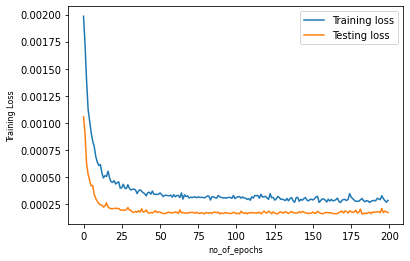

In [ ]:

plt.plot(lstm_history.history['loss'],label='Training loss' )
plt.plot(lstm_history.history['val_loss'], label='Testing loss')
plt.xlabel('no_of_epochs', fontsize=8 )
plt.ylabel('Training Loss', fontsize=8 )
plt.legend()

In [ ]:
train_yp = model_lstm.predict(x_train)
val_yp = model_lstm.predict(x_val)
test_yp = model_lstm.predict(x_test)



57/57 [==============================] - 0s 2ms/step


In [ ]:
train_yp.shape,test_yp.shape,val_yp.shape

((4378, 1), (1821, 1), (1094, 1))

In [ ]:
y_train.shape

(4378, 1)

In [ ]:
#reshape into the origional form (2-D)
x_train = x_train.reshape((x_train.shape[0],x_train.shape[2]))
x_val = x_val.reshape((x_val.shape[0],x_val.shape[2]))
x_test= x_test.reshape((x_test.shape[0],x_test.shape[2]))

In [ ]:
y_train.shape,x_train.shape,

((4378, 1), (4378, 14))

In [ ]:
#inverse_transform
#1)x_train
inv_x_train=pd.concat([pd.DataFrame(train_yp), pd.DataFrame(x_train[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_train)
y_train_prediction=rev_trans[:,0]

#y_train
inv_y_train=pd.concat([pd.DataFrame(y_train), pd.DataFrame(x_train[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_train)
y_train_Observed=rev_trans[:,0]

#1)x_val
inv_x_val=pd.concat([pd.DataFrame(val_yp), pd.DataFrame(x_val[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_val)
y_val_prediction=rev_trans[:,0]

#y_val
inv_y_val=pd.concat([pd.DataFrame(y_val), pd.DataFrame(x_val[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_val)
y_val_Observed=rev_trans[:,0]

#x_test
inv_x_test=pd.concat([pd.DataFrame(test_yp), pd.DataFrame(x_train[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_test)
y_test_prediction=rev_trans[:,0]

#y_test
inv_y_test=pd.concat([pd.DataFrame(y_test), pd.DataFrame(x_train[:, :3])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_test)
y_test_Observed=rev_trans[:,0]

In [ ]:
# y_train_pre=np.array(y_train_prediction)
# y_train_rev=np.array(y_train_Observed)
l=np.array([y_train_prediction,y_train_Observed])
dataset_train=pd.DataFrame(l)
dataset_train=dataset_train.transpose()
dataset_train.columns = ['Predicted', 'Observed']


Text(0, 0.5, 'Reservoir outflows (m^3/s)')

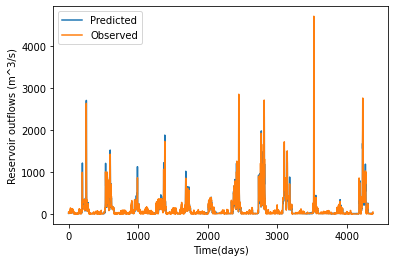

In [ ]:

dataset_train[['Predicted', 'Observed']].plot()
plt.xlabel("Time(days)")
plt.ylabel("Reservoir outflows (m^3/s)")

Text(0, 0.5, 'Reservoir outflows (m^3/s)')

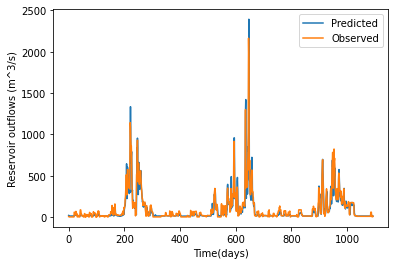

In [ ]:
l=np.array([y_val_prediction,y_val_Observed])
dataset_val=pd.DataFrame(l)
dataset_val=dataset_val.transpose()
dataset_val.columns = ['Predicted', 'Observed']
dataset_val[['Predicted', 'Observed']].plot()
plt.xlabel("Time(days)")
plt.ylabel("Reservoir outflows (m^3/s)")

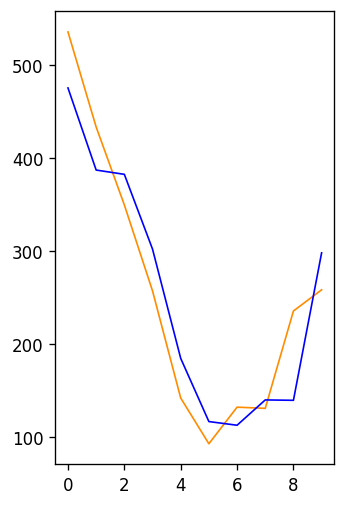

In [ ]:
pyplot.figure(figsize=(3,5), dpi=120)
pyplot.plot(y_train_Observed[3530:3540],'darkorange', label="Actual", lw=1)
pyplot.plot(y_train_prediction[3530:3540], 'b', label="Predicted", lw=1)

<ipython-input-248-8736dff8533e>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')


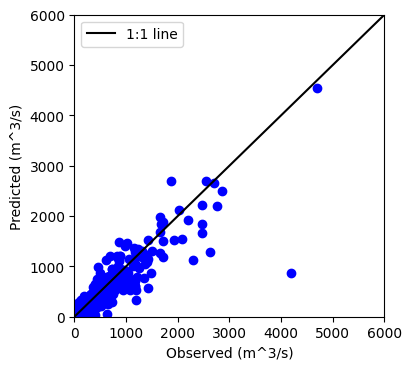

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(dataset_train.Observed,dataset_train.Predicted, color='b')
y_lim = plt.ylim([0, 6000])
x_lim = plt.ylim([0, 6000])
plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')
plt.ylim(y_lim)
plt.xlim(x_lim)
plt.xlabel("Observed (m^3/s)")
plt.ylabel("Predicted (m^3/s)")
plt.legend()

In [ ]:
#to save as csv file
# dataset.to_csv('/content/gdrive/MyDrive/2day_leadtime_results/shiv_1day_train_Observed_prediction_gru.csv')

In [ ]:
!pip install hydroeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from hydroeval import evaluator, nse
from sklearn.metrics import mean_squared_error

NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
RMSE_train = sqrt(mean_squared_error(y_train_Observed,y_train_prediction))
a1 = sum((y_train_Observed - np.mean(y_train_Observed)) * (y_train_prediction - np.mean(y_train_prediction)))
b1 = ((sum((y_train_Observed-np.mean(y_train_Observed))**2))**0.5) * ((sum((y_train_prediction-np.mean(y_train_prediction))**2))**0.5)
r2 = round((a1/b1)**2, 3)
print(NSE_train, RMSE_train, r2)

NSE_val = evaluator(nse,y_val_prediction , y_val_Observed )
RMSE_val = sqrt(mean_squared_error(y_val_Observed,y_val_prediction))
a1 = sum((y_val_Observed - np.mean(y_val_Observed)) * (y_val_prediction - np.mean(y_val_prediction)))
b1 = ((sum((y_val_Observed-np.mean(y_val_Observed))**2))**0.5) * ((sum((y_val_prediction-np.mean(y_val_prediction))**2))**0.5)
r2 = round((a1/b1)**2, 3)
print(NSE_val, RMSE_val, r2)

[0.87078979] 91.45522692207383 0.876
[0.84000261] 75.41172729692619 0.846


Text(0, 0.5, 'Reservoir outflows (m^3/s)')

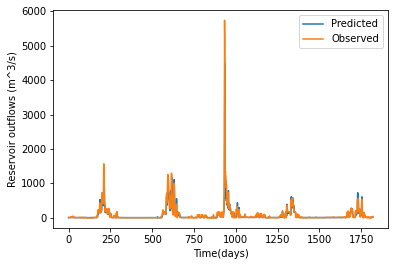

In [ ]:
#test
# y_test_prediction=np.array(y_test_prediction)
# y_test_Observed=np.array(y_test_Observed)
l1 = np.array([y_test_prediction,y_test_Observed])
dataset_test=pd.DataFrame(l1)
dataset_test=dataset_test.transpose()
dataset_test.columns = ['Predicted', 'Observed']
dataset_test[['Predicted','Observed']].plot()
plt.xlabel("Time(days)")
plt.ylabel("Reservoir outflows (m^3/s)")

In [ ]:
#test
# y_test_prediction=np.array(y_test_prediction)
# y_test_Observed=np.array(y_test_Observed)
#l1 = np.array([y_test_prediction[936:945],y_test_Observed[936:945]])
#dataset_test=pd.DataFrame(l1)
#dataset_test=dataset_test.transpose()
#dataset_test.columns = ['Predicted', 'Observed']
#dataset_test[['Predicted','Observed']].plot()
# pyplot.figure(figsize=(3,5), dpi=120)
# pyplot.plot(y_test_Observed[938:947],'darkorange', label="Actual", lw=1)
# pyplot.plot(y_test_prediction[938:947], 'b', label="Predicted", lw=1)
#plt.xlabel("Time(days)")
#plt.ylabel("Reservoir outflows (m^3/s)")

<ipython-input-254-6c6443f59ef9>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')


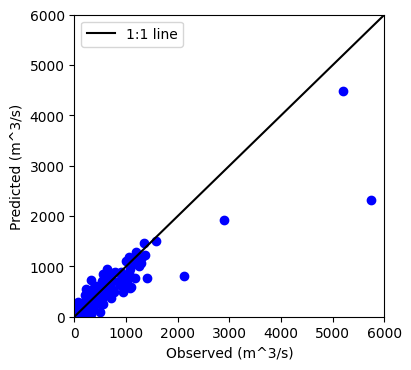

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(dataset_test.Observed,dataset_test.Predicted, color='b')
y_lim = plt.ylim([0, 6000])
x_lim = plt.ylim([0, 6000])
plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')
plt.ylim(y_lim)
plt.xlim(x_lim)
plt.xlabel("Observed (m^3/s)")
plt.ylabel("Predicted (m^3/s)")
plt.legend()

In [ ]:
y_test_prediction

array([ 9.00662639, 10.35102491, 10.14521904, ...,         nan,
               nan,         nan])

In [ ]:
test_result=np.array([y_test_prediction,y_test_Observed])
df_test=pd.DataFrame(test_result)
df_test=df_test.transpose()
df_test.columns = ['y_test_prediction','y_test_Observed']
#df_test.tail(1819)
final_test=df_test.drop(df_test.index[1821:])
final_test

,y_test_prediction,y_test_Observed
0,9.006626,10.648148
1,10.351025,7.291667
2,10.145219,7.291667
3,11.300873,7.291667
4,10.279965,7.291667
...,...,...
1816,17.100658,28.703704
1817,18.124163,28.472222
1818,18.079947,28.703704
1819,18.402930,42.939815


In [ ]:
NSE_test = evaluator(nse, final_test.y_test_prediction , final_test.y_test_Observed)
RMSE_test = sqrt(mean_squared_error(final_test.y_test_prediction, final_test.y_test_Observed))
a1 = sum((final_test.y_test_Observed - np.mean(final_test.y_test_Observed)) * (final_test.y_test_prediction - np.mean(final_test.y_test_prediction)))
b1 = ((sum((final_test.y_test_Observed - np.mean(final_test.y_test_Observed))**2))**0.5) * ((sum((final_test.y_test_prediction - np.mean(final_test.y_test_prediction))**2))**0.5)
r2 = round((a1/b1)**2, 3)
print(NSE_test, RMSE_test, r2)

[0.83949264] 106.41320165499668 0.865


In [ ]:
 #to save as csv file
#dataset.to_csv('/content/gdrive/MyDrive/2day_leadtime_results/shiv_1day_test_Observed_prediction_gru.csv')